# 00000: Nest analysis
Authors: Tobias G. Mueller, Mark A. Buckner
Last modified: 12/03/2024
Contact: __________

**Summary**: Here, we predict using out pretrained model. tile the prediction output and take a random 20% to be used for validation. We use the validation to calculate optimal confidence thresholds for predictions and output our final predictions along with performance metrics of the model

This script outputs 
- a yolov5 dataset of nest predictions
- metrics of model performance
(other inbetween things like tiles that quickly get reused but I dont think we need to mention that?)

The data used in this script was generated in:
    `preprocessing.ipynb`

In [1]:
# first check the wd
# this should be AIggregation folder, change if its not

import os

print("cwd is", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())


cwd is /home/tmueller/github/AIggregation/notebooks
cwd changed to /home/tmueller/github/AIggregation


In [ ]:
import fiftyone as fo
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction


image_directory = "datasets/drone_ortho/ortho_clip_23april.png"
model_path = "AIggregation_yolov5m/weights/best.pt"
export_directory = "datasets/export_predictions/temp"



# Import ortho image as a fiftyone dataset 
dataset_full = fo.Dataset.from_images(
    [image_directory]
)


# specify AI detection model to use for predictions
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path=model_path, #specify path to trained model
    confidence_threshold=0.25,
    device="cuda", # "cpu" or 'cuda' for GPU
)

# function for sliced predictions from sahi
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())

# slice at training image size
for sample in dataset_full.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample,
                         label_field="prediction",
                         slice_height=608, 
                         slice_width=608,
                         overlap_height_ratio = .4, 
                         overlap_width_ratio=.4
    )



#launch fiftyone session to see predictions
session = fo.launch_app(dataset_full)


#export predictions to save them
dataset_full.export(
        export_dir=export_directory,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="prediction",
        include_confidence=True
    )

# NEW NUMBERS BELOW FOR SINLGE PREDICITON 

# took xxx minutes for loading image and predictions with CPU (AMD Ryzen 5 5500 3.6 GHz 6-Core Processor)
# took 2m 38s minutes on GPU (EVGA SC GAMING GeForce GTX 1060 3GB 3 GB Video Card)
# 64 gb DDR4-3200 ram







 100% |█████████████████████| 1/1 [23.0ms elapsed, 0s remaining, 49.2 samples/s] 


12/03/2024 09:30:40 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [23.0ms elapsed, 0s remaining, 49.2 samples/s] 


 100% |█████████████████████| 1/1 [2.4m elapsed, 0s remaining, 0.0 samples/s] 


12/03/2024 09:33:07 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [2.4m elapsed, 0s remaining, 0.0 samples/s] 


In [82]:


''' 
To compare the predicitons vs a labeled test set, we tile the exports and ground truth a random 20% of the tiles.

The below script takes a folder with yolov5 formated images and labels, tiles them into specified size tiles and saves a percent of random tiles into a new folder. 


'''

# first set max image pixels to none
# otherwise pillow thinks its a bomb DOS attack 

from PIL import Image
Image.MAX_IMAGE_PIXELS = None


# run yolo_tile script for each prediction
%run scripts/yolo_tile_modified.py -source ./datasets/export_predictions -target ./datasets/testset/tiled_testset -ext .png  -size 608 -ratio 0.2


'''
    PARAMETERS:

    -source         Source folder with images and labels needed to be tiled. 
    -target         Target folder for a new sliced dataset. Default: 
    -ext            Image extension in a dataset. Default: .JPG
    -size           Size of a tile. Default: 608
    -ratio          test split ratio. Default: 0.2 (i.e. 20% of tiles in the test set)
'''

# the test subset images can now be annotated in labelstudio for groundtruth labels


Image: ./datasets/export_predictions/images/val/ortho_clip_23april.png
[(0, <POLYGON ((18918.295 11262.414, 19029.31 11262.414, 19029.31 11379.806, 1891...>, 0.988093), (0, <POLYGON ((23811.926 1058.273, 23928.837 1058.273, 23928.837 1173.296, 23811...>, 0.987098), (0, <POLYGON ((25237.944 737.699, 25361.159 737.699, 25361.159 857.817, 25237.94...>, 0.986552), (0, <POLYGON ((12023.72 2756.625, 12140.632 2756.625, 12140.632 2868.044, 12023....>, 0.986549), (0, <POLYGON ((22389.439 8869.395, 22526.429 8869.395, 22526.429 8983.32, 22389....>, 0.986458), (0, <POLYGON ((28346.507 3937.569, 28455.48 3937.569, 28455.48 4053.92, 28346.50...>, 0.986379), (0, <POLYGON ((16882.492 563.87, 16998.206 563.87, 16998.206 678.593, 16882.492 ...>, 0.986261), (0, <POLYGON ((25401.418 10603.523, 25535.635 10603.523, 25535.635 10715.739, 25...>, 0.985972), (0, <POLYGON ((12454.724 631.773, 12560.983 631.773, 12560.983 733.396, 12454.72...>, 0.985923), (0, <POLYGON ((16012.473 5834.112, 16123.664 5834.112, 

'\n    PARAMETERS:\n\n    -source         Source folder with images and labels needed to be tiled. \n    -target         Target folder for a new sliced dataset. Default: \n    -ext            Image extension in a dataset. Default: .JPG\n    -size           Size of a tile. Default: 608\n    -ratio          test split ratio. Default: 0.2 (i.e. 20% of tiles in the test set)\n'

 100% |█████████████████| 102/102 [193.1ms elapsed, 0s remaining, 528.2 samples/s]     
 100% |███████████████████| 95/95 [127.5ms elapsed, 0s remaining, 753.4 samples/s] 
 100% |█████████████████| 100/100 [128.7ms elapsed, 0s remaining, 787.1 samples/s] 
 100% |█████████████████| 165/165 [133.3ms elapsed, 0s remaining, 1.3K samples/s]  
Indexing dataset...
 100% |███████████████████| 95/95 [48.2ms elapsed, 0s remaining, 2.0K samples/s] 
Merging samples...
 100 [275.2ms elapsed, ? remaining, 363.4 samples/s] 
Indexing dataset...
 100% |█████████████████| 102/102 [56.4ms elapsed, 0s remaining, 1.8K samples/s] 
Merging samples...
 102 [387.3ms elapsed, ? remaining, 264.3 samples/s] 
Indexing dataset...
 100% |█████████████████| 111/111 [138.5ms elapsed, 0s remaining, 801.5 samples/s]     
Merging samples...
 165 [514.7ms elapsed, ? remaining, 321.4 samples/s] 



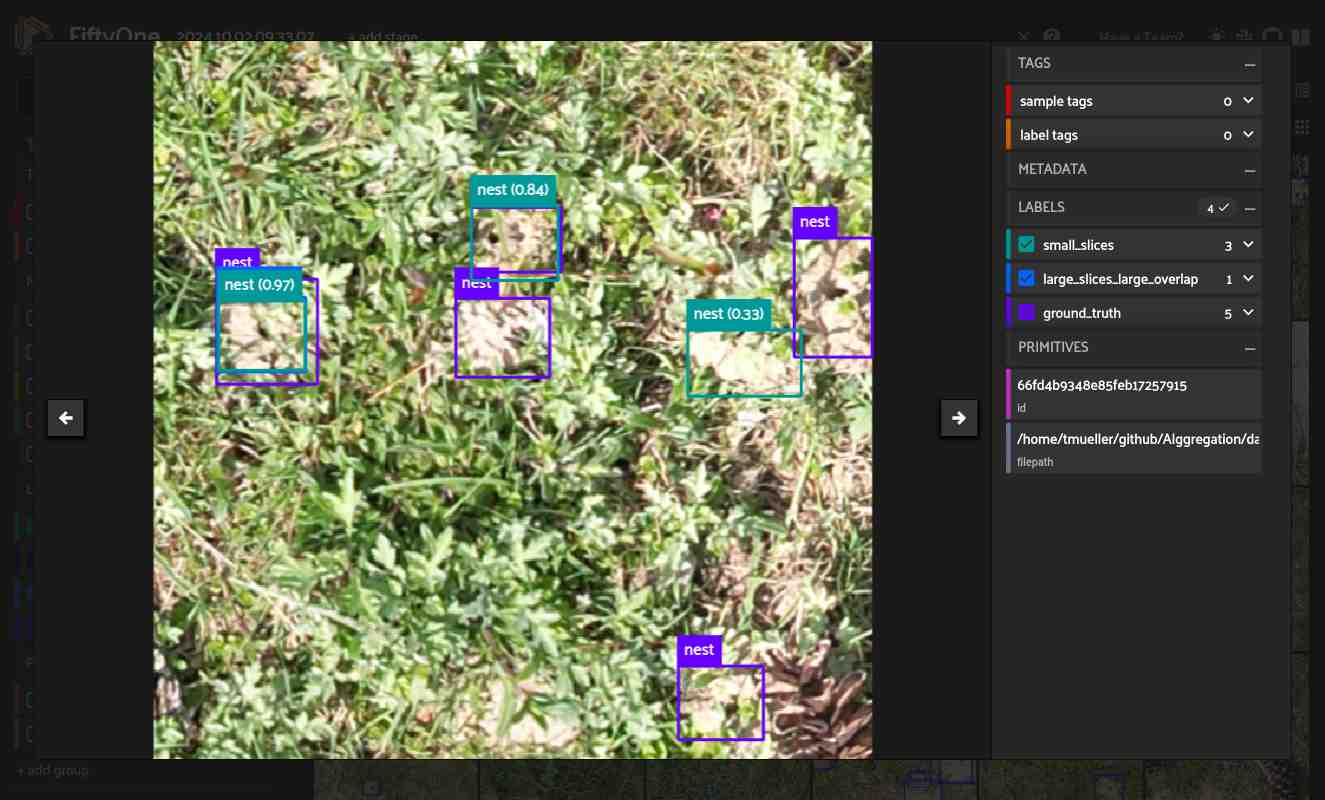

In [ ]:
'''
import the test subset as fiftyone datasets

then merge files with different labels to view them all at once

'''

gt_directory = "datasets/testset/groundtruth_testset" # whereever labelstudio export in yolov5 format
tiled_test_directory = "datasets/testset/tiled_testset" # target folder for file script


# first rename label studio outputs to have same name as fiftyone outputs (label studio adds weird strings upon export)
for root, dirs, files in os.walk(gt_directory):
    for file in files:
        oldname = os.path.join(root,file)
        if "-" in file:
            newname = file.split("-")[1]
            os.rename(oldname, os.path.join(root,newname))



# import in fiftyone
datasettest = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(tiled_test_directory, "data.yaml"),
    label_field= "predictions"
)

dataset_ground = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(gt_directory,"data.yaml"),
    label_field= "ground_truth"
)

# merge the datasets, ignoring that they are in different directories and instead merging images/labels with the same file name

key_fcn = lambda sample: os.path.basename(sample.filepath)

datasettest.merge_samples(dataset_ground, key_fcn=key_fcn)



# delete any oblong boxes from the test dataset
# these are created by splitting tiles through the middle of an existing bounding box
from fiftyone import ViewField as F

# Computes the dimensions of each bounding box in pixels
box_width, box_height = F("bounding_box")[2], F("bounding_box")[3]

# get rid of detections where one side of box is greater than 2.5 x the other
datasettest_keep=datasettest.select_fields("large_slices_large_overlap","ground_truth").filter_labels(
    "large_slices_large_overlap", (box_height < (box_width*2)) & (box_width < (box_height*2)), only_matches=False
)

# create a subset of just boxes that were removed incase you want to visualize
removed_boxes=datasettest.select_fields("large_slices_large_overlap").filter_labels(
    "large_slices_large_overlap", (box_height > (box_width*2)) | (box_width > (box_height*2)) 
)

# view that this worked
session = fo.launch_app(datasettest_keep)



Evaluating detections...
 100% |█████████████████| 165/165 [394.6ms elapsed, 0s remaining, 418.2 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 165/165 [420.8ms elapsed, 0s remaining, 392.1 samples/s]      
0.3923857790397764
              precision    recall  f1-score   support

        nest       0.93      0.71      0.81       227

   micro avg       0.93      0.71      0.81       227
   macro avg       0.93      0.71      0.81       227
weighted avg       0.93      0.71      0.81       227




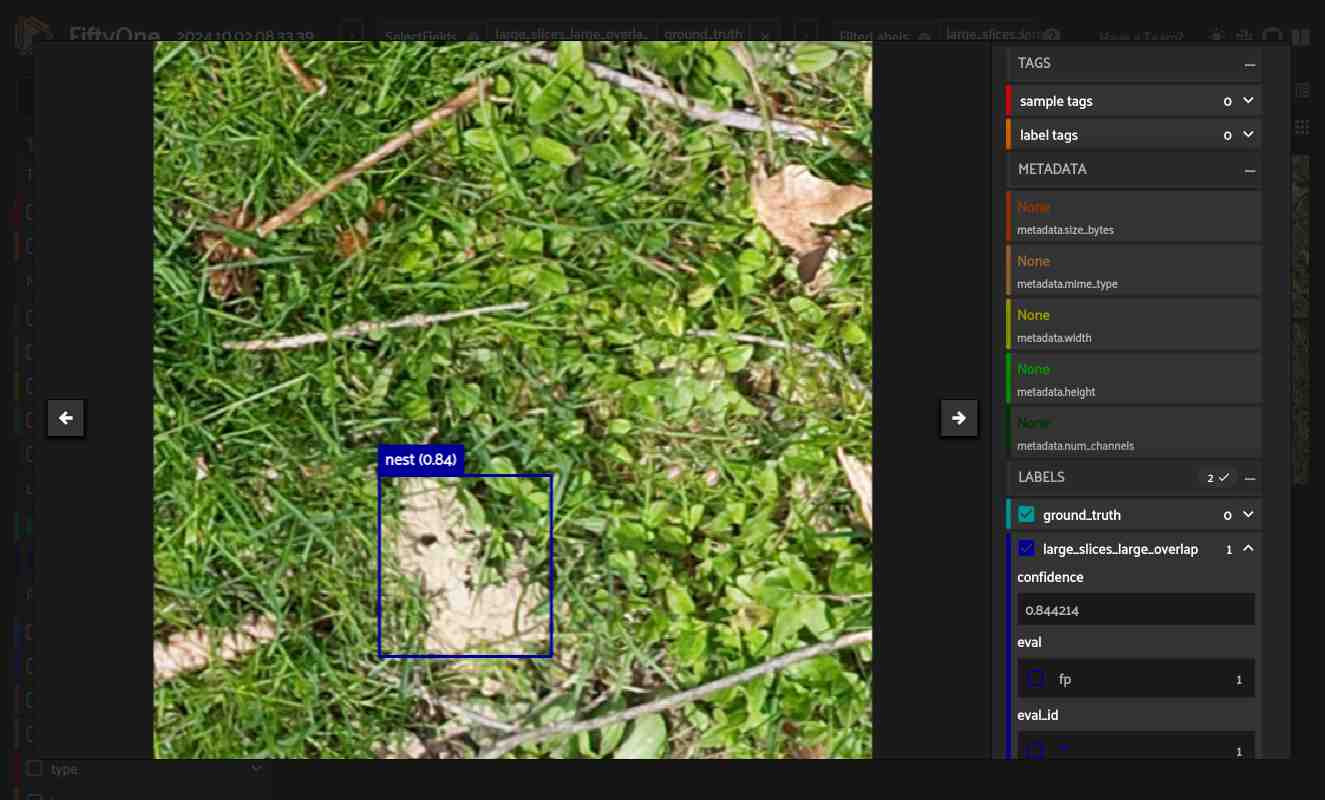

In [ ]:

# fine confidence threshold that gives highest f1 value


import scipy
from fiftyone import ViewField as F


dataset = datasettest
prediction = "predictions"
gt = "ground_truth"
lb = .3
ub = .9


# function to calculate the f1 score of a model
def calculate_f1(conf, dataset, prediction, gt):
    conf_view = dataset.filter_labels(prediction, F("confidence") >= conf)
    results = conf_view.evaluate_detections(prediction,
        gt_field= gt,
        eval_key="eval",
        missing="fn")

    fp = sum(conf_view.values("eval_fp"))
    tp = sum(conf_view.values("eval_tp"))
    fn = sum(conf_view.values("eval_fn"))

    f1 = tp/(tp+0.5*(fp+fn))

    return -1.0*f1  #make output negative to use fminbound

# function find the optimal output of the above function
def optimize_conf(lb, ub, dataset, gt, prediction):

    res = scipy.optimize.fminbound(
                    func=calculate_f1,
                    x1=lb,
                    x2=ub,
                    args=(dataset, prediction, gt),
                    xtol=0.01,
                    full_output=True
    )

    best_conf, f1val, ierr, numfunc = res
    maxf1 = -1.0*f1val
    print("\n \n     best f1          at confidence")
    print(maxf1, best_conf)
    return maxf1, best_conf


# save first output, maxf1, to a variable and use it to filder predictions
bestf1 = optimize_conf(lb=lb, ub=ub, dataset=dataset, gt=gt, prediction=prediction)[0]



# evaluate model performance at best conf threshold
high_f1_view = datasettest_keep.filter_labels("predictions", F("confidence") > bestf1, only_matches=False)

results_f1 = high_f1_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="predictions",
    compute_mAP=True
)

# print performance results
print(results_f1.mAP())
results_f1.print_report()


# create views for false positives and false negatives
fp_view = high_f1_view.to_evaluation_patches(eval_key="predictions").match(F("type")=="fp").sort_by("predictions.detection.confidence")
fn_view = high_f1_view.to_evaluation_patches(eval_key="predictions").match(F("type")=="fn").sort_by("predictions.detection.confidence")

# view false positives
#session.view = fp_view.view()

#view false negatives
#session.view = fn_view.view()



In [ ]:
# filter full predictions at same confidence threshold and export

full_export_directory = "datasets/export_predictions/final"


dataset_full_f1 = dataset_full.filter_labels("predictions", F("confidence") > bestf1, only_matches=False)

dataset_full_f1.export(
        export_dir=full_export_directory,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="prediction",
        include_confidence=True
    )


